# Area of a circle using Monte-Carlo

_Written by Jean-Loup Tastet on 2018-02-06._

_Inspired by D. Jason Koskinen's code._

Without knowing the value of $\pi$, calculate the area of a circle and make a plot of the method.
Hint: use $x^2+y^2=r^2$ and Monte-Carlo rejection sampling (accept / reject method).

In [1]:
import numpy as np
from numpy.random import rand, seed
# Don't print full arrays, but just their beginning and end.
np.set_printoptions(threshold=20, edgeitems=5)

In [2]:
# Seed the NumPy random number generator, for reproducibility
seed(42) # Comment out this line to get random results

### Randomly sample from the circle

In [3]:
def sample_in_circle(Nthrows, radius):
    '''
    Samples `Nthrows` points from a circle of given radius,
    centered at the origin.
    '''
    # Draw random numbers in [0,1).
    xunit = rand(Nthrows)
    yunit = rand(Nthrows)
    # Rescale them linearly such that their distribution is uniform
    # over the interval [-radius, +radius).
    x = radius * (2*xunit-1)
    y = radius * (2*yunit-1)
    # Compute the distance of each point to the center / origin.
    r = np.sqrt(x**2 + y**2)
    # Check which points are inside the circle.
    inside_circle = r < radius
    return x, y, inside_circle

Let's try with $100$ throws and $r=5.2$.

In [4]:
Nthrows = 100
radius = 5.2
x, y, inside = sample_in_circle(Nthrows, radius)

In [5]:
x

array([-1.30478276,  4.68742879,  2.41273699,  1.02604824, -3.57740614,
       ..., -0.0645258 ,  0.23642143, -0.75357341, -4.93564108,
       -4.07792916])

In [6]:
y

array([-4.87313647,  1.41866828, -1.9306978 ,  0.08913519,  4.23869133,
       ..., -1.56822042,  2.34993906,  4.1299467 ,  4.02569881,
        2.91070568])

In [7]:
inside

array([ True,  True,  True,  True, False, ...,  True,  True,  True, False,
        True])

Doesn't seem too bad. But how can we make sure that it indeed works properly?

### Let's plot it!

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

In [9]:
def plot_samples(x, y, inside, radius, save_to=None):
    '''
    Plots our random points, along with the circle and
    the square in which the points are drawn.
    Accepted points are in blue, rejected ones in red.
    '''
    fig, ax = plt.subplots(figsize=(7,7))
    # Let's use blue for points inside the circle,
    # and red for points outside.
    color = np.where(inside, 'b', 'r')
    ax.scatter(x, y, color=color)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation='horizontal')
    # Set the aspect ratio to 1:1
    ax.set_aspect('equal')
    ax.grid(color='80', linestyle=':')
    circle = Circle((0, 0), radius, facecolor='none',
        edgecolor='k', linewidth=2, linestyle=':')
    square = Rectangle((-radius, -radius), 2*radius, 2*radius,
        facecolor='none', edgecolor='k', linewidth=2)
    ax.add_patch(circle)
    ax.add_patch(square)
    # Use this option to save the figure.
    # The format is inferred from the file extension.
    if save_to is not None:
        fig.savefig(save_to)

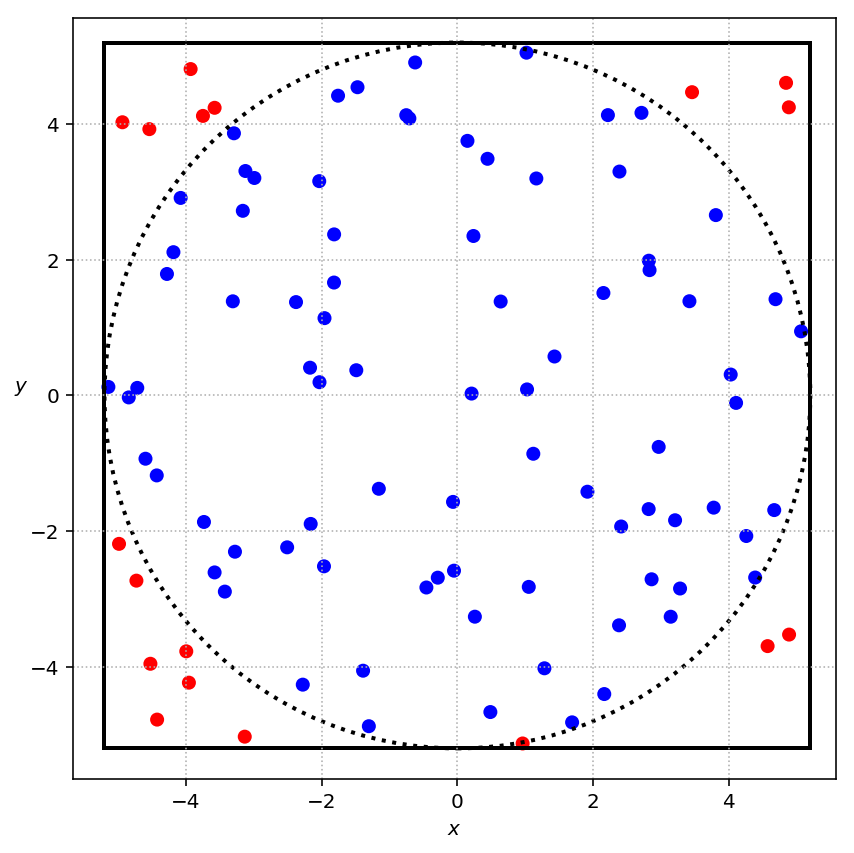

In [10]:
plot_samples(x, y, inside, radius)
#plot_samples(x, y, inside, radius, save_to="circle.pdf")

### Now let's estimate the area of the circle

We draw from a square of area $A_{\mathrm{sq}} = (2r)^2$, and we accept a fraction $f_{\mathrm{acc}}$ of the points. Since the distribution is uniform, the expectation value for this fraction is:

$$\mathbb{E}[f_{\mathrm{acc}}] = \frac{A_{\mathrm{circ}}}{A_{\mathrm{sq}}}$$

frow what it follows:

$$A_{\mathrm{circ}} = 4 r^2 \mathbb{E}[f_{\mathrm{acc}}]$$

Given a finite number of throws, we can approximate:

$$A_{\mathrm{circ}} \approx 4 r^2 f_{\mathrm{acc}}$$

In [11]:
def estimate_area(Nthrows, inside, radius):
    'Estimates the area of the circle as A ≈ 4r²×f_acc.'
    f_acc = np.sum(inside) / Nthrows
    area = 4 * radius**2 * f_acc
    return area

In [12]:
estimate_area(Nthrows, inside, radius)

88.69120000000001

Let's compare this result to the exact area $A_{\mathrm{circ}} = \pi r^2$.

In [13]:
np.pi * radius**2

84.94866535306801

Not too bad! (But not really good either...)

### Now let's do $1000$ trials

In [14]:
def generate_area_estimate(Nthrows, radius):
    'Randomly samples points and estimates the area.'
    # Notice how, when using functions, our global variables
    # `x`, `y` and `inside` defined above are **not** affected.
    # Here, `x`, `y` and `inside` are new local variables.
    x, y, inside = sample_in_circle(Nthrows, radius)
    area = estimate_area(Nthrows, inside, radius)
    return area

In [15]:
def generate_multiple_area_estimates(Ntrials, Nthrows, radius):
    'Samples points and estimates the area for multiple independent trials.'
    areas = np.zeros(Ntrials)
    for i in range(Ntrials):
        areas[i] = generate_area_estimate(Nthrows, radius)
    return areas

In [16]:
Ntrials = 1000
areas = generate_multiple_area_estimates(Ntrials, Nthrows, radius)

Let's histogram the results.

In [17]:
def plot_areas(areas, binwidth):
    '''
    Plots a histogram of the area estimates.
    The `binwidth` parameter allows to specify a precise bin width.
    '''
    fig, ax = plt.subplots(figsize=(8,6))
    # Here we need to use precise bin widths.
    # The following code is inspired by this answer:
    #     https://stackoverflow.com/a/12176344
    edges = np.arange(np.min(areas), np.max(areas)+binwidth, binwidth)
    # Pass the bin edges to hist()
    ax.hist(areas, bins=edges)
    ax.set_title('Bin width: {}'.format(binwidth))

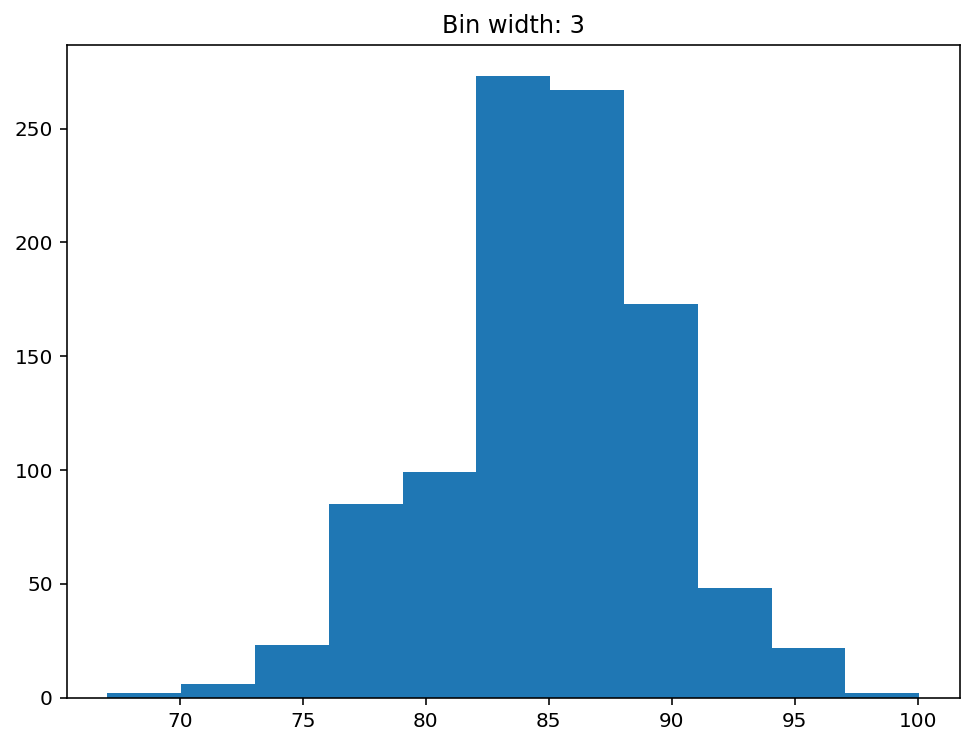

In [18]:
plot_areas(areas, 3)

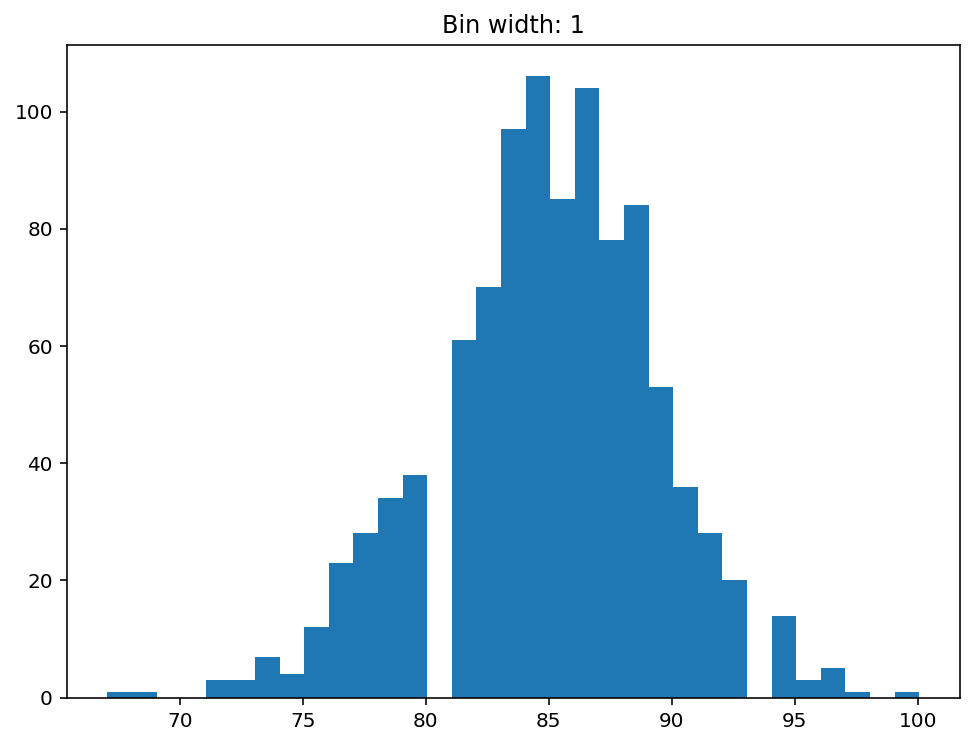

In [19]:
plot_areas(areas, 1)

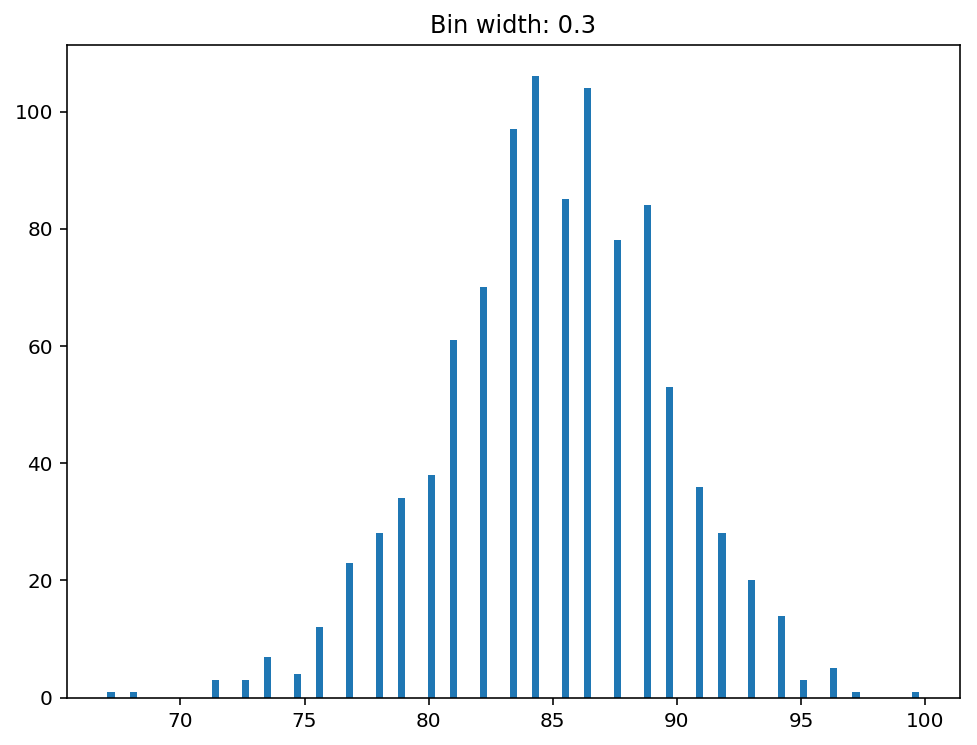

In [20]:
plot_areas(areas, 0.3)

Why do we see gaps?


## Computation of $\pi$

We saw that $A_{\mathrm{circ}} = 4 r^2 \mathbb{E}[f_{\mathrm{acc}}]$. Knowing that $A_{\mathrm{circ}} = \pi r^2$, we can deduce the value of $\pi$:

$$\pi = \frac{A_{\mathrm{circ}}}{r^2} = 4 \mathbb{E}[f_{\mathrm{acc}}]$$

Let's estimate it.

In [21]:
def estimate_pi(Nthrows, radius):
    'Samples points and estimates π from the area.'
    area = generate_area_estimate(Nthrows, radius)
    pi_est = area / radius**2
    return pi_est

In [22]:
estimate_pi(10, radius)

3.2000000000000006

Hmm... Could be better :-/

Let's try with more throws and see how our estimate changes.

In [23]:
Nthrow_range = [10, 100, 1000, 10000, 100000]
pi_estimates = [estimate_pi(Nthrows, radius)
                for Nthrows in Nthrow_range]

In [24]:
pi_estimates

[3.6, 3.0, 3.04, 3.1412, 3.1426]

Things slowly get better...

In [25]:
more_Nthrows = np.arange(100, stop=100000, step=1000)
more_pi_estimates = [estimate_pi(Nthrows, radius)
                    for Nthrows in more_Nthrows]

In [26]:
def plot_pi_estimates(Nthrow_range, estimates, save_to=None):
    'Plots our π estimates as a function of the number of sampling points.'
    fig, ax = plt.subplots(figsize=(8,5))
    ax.set_xlabel('Samples')
    ax.set_ylabel('$\pi$ estimate')
    ax.scatter(Nthrow_range, estimates)
    ax.axhline(np.pi, color='r', label='True $\pi$')
    ax.grid(color='60', linestyle=':')
    ax.legend()
    ax.autoscale(enable=True, axis='x', tight=True)
    if save_to is not None:
        fig.savefig(save_to)

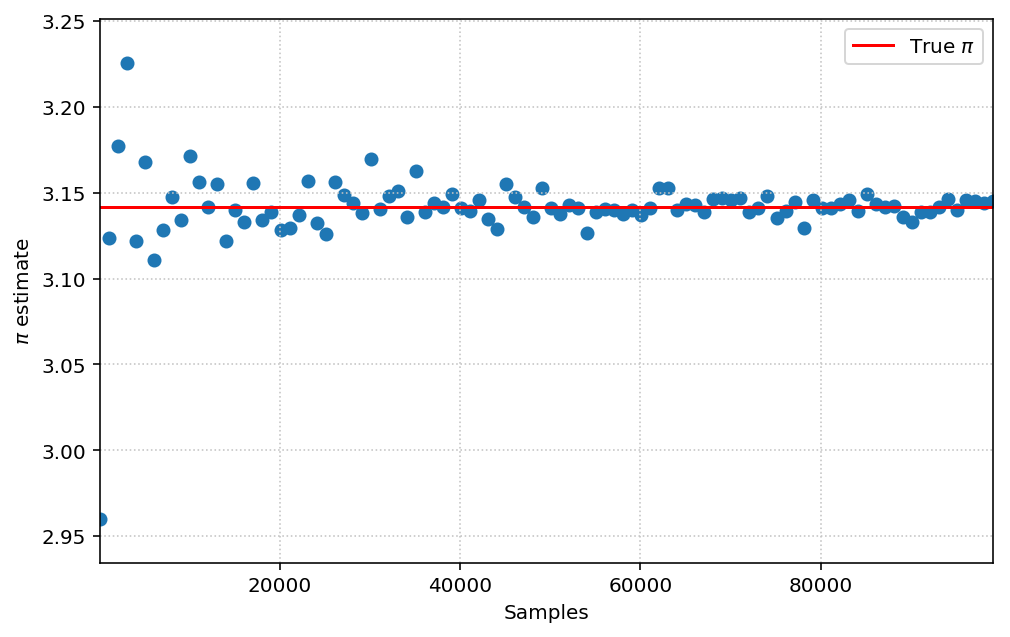

In [27]:
plot_pi_estimates(more_Nthrows, more_pi_estimates)

## Central Limit Theorem

In [28]:
from scipy.stats import norm

In [29]:
def test_clt(Ntrials, Nthrows, bins=None):
    'Compares the distribution of our π estimates to a Gaussian.'
    pi_estimates = [estimate_pi(Nthrows, radius)
                        for _ in range(Ntrials)]
    fig, ax = plt.subplots(figsize=(8,6))
    # Let's normalize the histogram to make it easier to
    # compare with the Gaussian distribution.
    # We use the `density=True` option for that.
    # Note: in Matplotlib < 3, this is `normed=True`.
    ax.hist(pi_estimates, density=True, bins=bins, label='$\pi$ estimates')
    # Now compare with a gaussian distribution of tandard
    # deviation π / (2√N).
    sigma = np.pi / (2*np.sqrt(Nthrows))
    x = np.linspace(np.pi-3.5*sigma, np.pi+3.5*sigma, num=200)
    y = norm.pdf(x, loc=np.pi, scale=sigma)
    ax.plot(x, y, color='k', label='Gaussian')
    ax.legend()

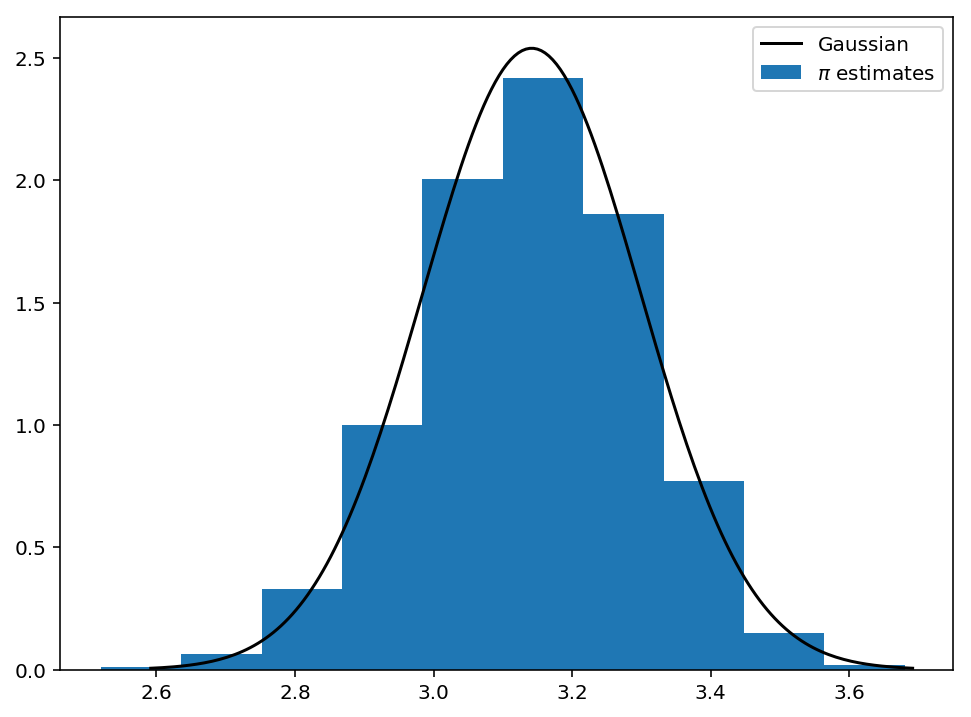

In [30]:
test_clt(10000, 100)